<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/FOR11_source_target_dynamics_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOR 11
## Medical and Health Sciences

**Dataset description:**\
`researcher_idx:` a unique index for each researcher pair\
`researcher_id:` a unique identifier for each researcher\
`time1 and time2:` the two time periods being compared\
`cosine_similarity:` the cosine similarity between the research profiles of the two researchers in the pair\
`angular_similarity_deg:` the angular similarity (in degrees) between the research profiles of the two researchers in the pair\
`source_grid, target_grid, and grid_id:` identifiers for the researchers' organizations\
`organization_name and t_organization_name_target:` the names of the source and target organizations for the researchers in the pair\
`p_fractional:` fractional count of publications for the source institution\
`tcs:` total citation score for the source institution\
`mcs:` mean citation score for the source institution\
`tncs:` total normalized citation score for the source institution\
`mncs:` mean normalized citation score for the source institution\
`p_top_10_prop:` proportion of publications in the top 1% for the source institution\
`pp_top_10_prop:` proportion of top 1% publications per researcher for the source institution\
`t_p_fractional_target:` fractional count of publications for the target institution\
`t_tcs_target:` total citation score for the target institution\
`t_mcs_target:` mean citation score for the target institution\
`t_tncs_target:` total normalized citation score for the target institution\
`t_mncs_target:` mean normalized citation score for the target institution\
`t_p_top_10_prop_target:` proportion of publications in the top 1% for the target institution\
`t_pp_top_10_prop_target:` proportion of top 1% publications per researcher for the target institution

In [1]:
#@title Install drivers
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
#!pip install pynput
#pip install plotly==5.4.0
!pip install patool

# main libraries
import psutil
import humanize
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import torch
import nltk
import GPUtil as GPU
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

# plotting
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
!pip install statannot
plt.style.use('ggplot')
%matplotlib inline

# Google big query
from google.cloud import bigquery
from google.colab import files
%load_ext google.colab.data_table
%load_ext google.cloud.bigquery

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mon May 15 09:37:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Load intermediary data
similarity_df = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/similarity_df_six_plus_merged_for11.csv')
ranks_df = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/grid_ranks_for11.csv')

print(similarity_df.head())
print(ranks_df.head())

In [ ]:
#@title Preprocessing 
# make the dataset more maneagable by filtering out all sources and grids which are not at the top 1000 organisations ranked by PPtop1%
df_target = similarity_df.merge(ranks_df, left_on='target_grid', right_on='grid_id', how='inner')
df_source = similarity_df.merge(ranks_df, left_on='source_grid', right_on='grid_id', how='inner')
#df_target.head()
#print(df_source.head())

# Merge dataset2 to dataset1 based on source_grid
merged_data_source = similarity_df.merge(ranks_df, left_on='source_grid', right_on='grid_id', suffixes=('', '_source'))

# Merge dataset2 to dataset1 based on target_grid
merged_data_target = merged_data_source.merge(ranks_df, left_on='target_grid', right_on='grid_id', suffixes=('', '_target'))

merged_data_target.reset_index(drop=True, inplace=True)

# Rename the columns
merged_data_target.columns = [f't_{col}' if col.endswith('_target') else col for col in merged_data_target.columns]

# Save and read the resulting dataset to/from a CSV file
merged_data_target.to_csv('/content/drive/MyDrive/TRANSFORMATION/for11_combined.csv', index=False, encoding="utf-8")
#df = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/for11_combined.csv')
#print(df.columns)
#print(df.head())

In [2]:
#@title Load combined data
df = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/for11_combined.csv')
df = df[df['pp_top_10_prop'] >= 0.005].reset_index(drop=True)
print(df.columns)

# load organization type data from GBQ
from google.cloud import bigquery
from google.colab import files
%load_ext google.colab.data_table
%load_ext google.cloud.bigquery

# Provide your credentials to the runtime
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# declare your project 
project_id = "cshdimensionstest"

client = bigquery.Client(project=project_id)

sql = """
SELECT id, name,  status, established, types, wikipedia_url, address.latitude, address.longitude, address.city, address.country, address.country_code 
FROM `dimensions-ai.data_analytics.grid` 
WHERE status = 'active'
ORDER BY id, established
"""
organisations_metadata = client.query(sql).to_dataframe()

# Remove [''] pattern from the 'types' column
organisations_metadata['types'] = organisations_metadata['types'].astype(str)
organisations_metadata['types'] = organisations_metadata['types'].str.strip("[]").str.replace("'", "")

organisations_metadata.head(10)
print(organisations_metadata.types.unique())

Index(['researcher_idx', 'researcher_id', 'time1', 'time2',
       'cosine_similarity', 'angular_similarity_deg', 'source_grid',
       'target_grid', 'grid_id', 'organization_name', 'for_division_id',
       'for_division', 'p_fractional', 'tcs', 'mcs', 'tncs', 'mncs',
       'p_top_10_prop', 'pp_top_10_prop', 't_grid_id_target',
       't_organization_name_target', 't_for_division_id_target',
       't_for_division_target', 't_p_fractional_target', 't_tcs_target',
       't_mcs_target', 't_tncs_target', 't_mncs_target',
       't_p_top_10_prop_target', 't_pp_top_10_prop_target'],
      dtype='object')
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
Authenticated
['Education' 'Government' 'Nonprofit' 'Facility' 'Company' 'Healthcare'
 'Archive' 'Other' '']


In [ ]:
#@title Individual dynamics all org types - overview
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.hist(df['cosine_similarity'], bins=30, edgecolor='black')
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['angular_similarity_deg'], bins=30, edgecolor='black')
plt.title('Angular Similarity Distribution')
plt.xlabel('Angular Similarity (Degrees)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# series
mean_angular_similarity_deg = df.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['time1'], mean_angular_similarity_deg['angular_similarity_deg'], label='Mean Angular Similarity')

plt.title('Mean Cosine and Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# series with rolling window

mean_angular_similarity_deg = df.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

# Calculate mean angular similarity for each year
mean_angular_similarity_deg['year'] = (mean_angular_similarity_deg['time1'] + mean_angular_similarity_deg['time2']) // 2

# Calculate the rolling mean with a window of 4 years
mean_angular_similarity_deg['rolling_mean_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).mean()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

plt.title('Mean Angular Similarity over Time (4y rolling window')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Calculate the rolling standard deviation with a window of 4 years
mean_angular_similarity_deg['rolling_std_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).std()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

# Add the shadowing for the standard deviation
plt.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')

plt.title('Mean Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Plot the number of data points for each period as a bar chart

data_points_count = df.groupby(['time1', 'time2']).size().reset_index(name='count')

# Calculate the count for each year
data_points_count['year'] = (data_points_count['time1'] + data_points_count['time2']) // 2

plt.figure(figsize=(9, 3))
plt.bar(data_points_count['year'], np.log(data_points_count['count']))
plt.title('Number of Data Points per Period')
plt.xlabel('Time Periods')
plt.ylabel('Count(log)')


plt.tight_layout()
plt.show()

In [ ]:
#@title Individual dynamics all org types - overview combined
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the rolling mean angular similarity with standard deviation shadowing
color = 'tab:blue'
ax1.set_title('Mean Angular Similarity and Data Points Count over Time')
ax1.set_xlabel('Time Periods')
ax1.set_ylabel('Mean Angular Similarity', color=color)
ax1.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], color=color, label='Rolling Mean Angular Similarity (4 Years)')
ax1.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a second y-axis to plot the number of data points for each period
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Data Points Count', color=color)
ax2.bar(data_points_count['year'], np.log(data_points_count['count']), color=color, alpha=0.3, label='Data Points Count (Log)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
#@title Individual dynamics all Education Org Types - overview
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

edu_organisations = organisations_metadata[organisations_metadata['types'] == 'Education']
df_edu = df.merge(edu_organisations, left_on='target_grid', right_on='id').drop_duplicates()

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.hist(df_edu['cosine_similarity'], bins=30, edgecolor='black')
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_edu['angular_similarity_deg'], bins=30, edgecolor='black')
plt.title('Angular Similarity Distribution')
plt.xlabel('Angular Similarity (Degrees)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# series education
# Filter organisations_metadata to include only rows with 'Education' in the 'types' column

mean_angular_similarity_deg = df_edu.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['time1'], mean_angular_similarity_deg['angular_similarity_deg'], label='Mean Angular Similarity')

plt.title('Mean Cosine and Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# series with rolling window

mean_angular_similarity_deg = df_edu.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

# Calculate mean angular similarity for each year
mean_angular_similarity_deg['year'] = (mean_angular_similarity_deg['time1'] + mean_angular_similarity_deg['time2']) // 2

# Calculate the rolling mean with a window of 4 years
mean_angular_similarity_deg['rolling_mean_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).mean()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

plt.title('Mean Angular Similarity over Time (4y rolling window')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Calculate the rolling standard deviation with a window of 4 years
mean_angular_similarity_deg['rolling_std_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).std()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

# Add the shadowing for the standard deviation
plt.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')

plt.title('Mean Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Plot the number of data points for each period as a bar chart

data_points_count = df_edu.groupby(['time1', 'time2']).size().reset_index(name='count')

# Calculate the count for each year
data_points_count['year'] = (data_points_count['time1'] + data_points_count['time2']) // 2

plt.figure(figsize=(9, 3))
plt.bar(data_points_count['year'], np.log(data_points_count['count']))
plt.title('Number of Data Points per Period')
plt.xlabel('Time Periods')
plt.ylabel('Count(log)')


plt.tight_layout()
plt.show()

In [ ]:
#@title Individual dynamics all Healthcare Org Types - overview
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

health_organisations = organisations_metadata[organisations_metadata['types'] == 'Healthcare']
df_health = df.merge(health_organisations, left_on='target_grid', right_on='id').drop_duplicates()

plt.figure(figsize=(8, 3))


plt.subplot(1, 2, 1)
plt.hist(df_health['cosine_similarity'], bins=30, edgecolor='black')
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')



plt.subplot(1, 2, 2)
plt.hist(df_health['angular_similarity_deg'], bins=30, edgecolor='black')
plt.title('Angular Similarity Distribution')
plt.xlabel('Angular Similarity (Degrees)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# series 
mean_angular_similarity_deg = df_health.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['time1'], mean_angular_similarity_deg['angular_similarity_deg'], label='Mean Angular Similarity')

plt.title('Mean Cosine and Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# series with rolling window

mean_angular_similarity_deg = df_health.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

# Calculate mean angular similarity for each year
mean_angular_similarity_deg['year'] = (mean_angular_similarity_deg['time1'] + mean_angular_similarity_deg['time2']) // 2

# Calculate the rolling mean with a window of 4 years
mean_angular_similarity_deg['rolling_mean_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).mean()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

plt.title('Mean Angular Similarity over Time (4y rolling window')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Calculate the rolling standard deviation with a window of 4 years
mean_angular_similarity_deg['rolling_std_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).std()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

# Add the shadowing for the standard deviation
plt.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')

plt.title('Mean Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Plot the number of data points for each period as a bar chart

data_points_count = df_health.groupby(['time1', 'time2']).size().reset_index(name='count')

# Calculate the count for each year
data_points_count['year'] = (data_points_count['time1'] + data_points_count['time2']) // 2

plt.figure(figsize=(9, 3))
plt.bar(data_points_count['year'], np.log(data_points_count['count']))
plt.title('Number of Data Points per Period')
plt.xlabel('Time Periods')
plt.ylabel('Count(log)')


plt.tight_layout()
plt.show()

In [ ]:
#@title Individual dynamics all Government Org Types - overview
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

gov_organisations = organisations_metadata[organisations_metadata['types'] == 'Government']
df_gov = df.merge(gov_organisations, left_on='target_grid', right_on='id').drop_duplicates()

plt.figure(figsize=(8, 3))


plt.subplot(1, 2, 1)
plt.hist(df_gov['cosine_similarity'], bins=30, edgecolor='black')
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')



plt.subplot(1, 2, 2)
plt.hist(df_gov['angular_similarity_deg'], bins=30, edgecolor='black')
plt.title('Angular Similarity Distribution')
plt.xlabel('Angular Similarity (Degrees)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# series education
# Filter organisations_metadata to include only rows with 'Education' in the 'types' column

mean_angular_similarity_deg = df_gov.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['time1'], mean_angular_similarity_deg['angular_similarity_deg'], label='Mean Angular Similarity')

plt.title('Mean Cosine and Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# series with rolling window

mean_angular_similarity_deg = df_gov.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

# Calculate mean angular similarity for each year
mean_angular_similarity_deg['year'] = (mean_angular_similarity_deg['time1'] + mean_angular_similarity_deg['time2']) // 2

# Calculate the rolling mean with a window of 4 years
mean_angular_similarity_deg['rolling_mean_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).mean()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

plt.title('Mean Angular Similarity over Time (4y rolling window')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Calculate the rolling standard deviation with a window of 4 years
mean_angular_similarity_deg['rolling_std_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).std()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

# Add the shadowing for the standard deviation
plt.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')

plt.title('Mean Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Plot the number of data points for each period as a bar chart
data_points_count = df_gov.groupby(['time1', 'time2']).size().reset_index(name='count')

# Calculate the count for each year
data_points_count['year'] = (data_points_count['time1'] + data_points_count['time2']) // 2

plt.figure(figsize=(9, 3))
plt.bar(data_points_count['year'], np.log(data_points_count['count']))
plt.title('Number of Data Points per Period')
plt.xlabel('Time Periods')
plt.ylabel('Count(log)')


plt.tight_layout()
plt.show()

In [ ]:
#@title Individual dynamics all Company Org Types - overview
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

company_organisations = organisations_metadata[organisations_metadata['types'] == 'Company']
df_company = df.merge(company_organisations, left_on='target_grid', right_on='id').drop_duplicates()

plt.figure(figsize=(8, 3))


plt.subplot(1, 2, 1)
plt.hist(df_company['cosine_similarity'], bins=30, edgecolor='black')
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')



plt.subplot(1, 2, 2)
plt.hist(df_company['angular_similarity_deg'], bins=30, edgecolor='black')
plt.title('Angular Similarity Distribution')
plt.xlabel('Angular Similarity (Degrees)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# series education
# Filter organisations_metadata to include only rows with 'Education' in the 'types' column
mean_angular_similarity_deg = df_company.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['time1'], mean_angular_similarity_deg['angular_similarity_deg'], label='Mean Angular Similarity')

plt.title('Mean Cosine and Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# series with rolling window

mean_angular_similarity_deg = df_company.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

# Calculate mean angular similarity for each year
mean_angular_similarity_deg['year'] = (mean_angular_similarity_deg['time1'] + mean_angular_similarity_deg['time2']) // 2

# Calculate the rolling mean with a window of 4 years
mean_angular_similarity_deg['rolling_mean_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).mean()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

plt.title('Mean Angular Similarity over Time (4y rolling window')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Calculate the rolling standard deviation with a window of 4 years
mean_angular_similarity_deg['rolling_std_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).std()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

# Add the shadowing for the standard deviation
plt.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')

plt.title('Mean Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Plot the number of data points for each period as a bar chart

data_points_count = df_company.groupby(['time1', 'time2']).size().reset_index(name='count')

# Calculate the count for each year
data_points_count['year'] = (data_points_count['time1'] + data_points_count['time2']) // 2

plt.figure(figsize=(9, 3))
plt.bar(data_points_count['year'], np.log(data_points_count['count']))
plt.title('Number of Data Points per Period')
plt.xlabel('Time Periods')
plt.ylabel('Count(log)')


plt.tight_layout()
plt.show()

In [21]:
#@title Inflow, outflow counts -- all types
import plotly.express as px

# Calculate outflow and inflow counts
outflow_counts = df_edu.groupby('source_grid')['researcher_idx'].count().reset_index().rename(columns={'researcher_idx': 'outflow_count'})
inflow_counts = df_edu.groupby('target_grid')['researcher_idx'].count().reset_index().rename(columns={'researcher_idx': 'inflow_count'})

outflow_counts = outflow_counts[outflow_counts['outflow_count'] >= 200]
inflow_counts = inflow_counts[inflow_counts['inflow_count'] >= 200]

# Calculate average angular similarity
mean_similarity_t = df_edu.groupby('target_grid')['angular_similarity_deg'].mean().reset_index().rename(columns={'angular_similarity_deg': 'mean_similarity'})                                                                                                 

# Education Institutions Only

In [ ]:
#@title Mean similarity, flows and p_top(1%) scatterplots -- all types
# Merge the counts and p_top_10_prop values, drop duplicates, and select the relevant columns
df_edu_outflow = df_edu[['source_grid', 'p_top_10_prop', 'organization_name', 'mncs']].merge(outflow_counts, on='source_grid').drop_duplicates()
df_edu_inflow = df_edu[['target_grid', 't_p_top_10_prop_target', 't_organization_name_target', 't_mncs_target']].merge(inflow_counts, on='target_grid').drop_duplicates()
df_edu_inflow_similarity = df_edu_inflow.merge(mean_similarity_t, on='target_grid')

# Create new columns to indicate if mncs or t_mncs_target are above 1.2
df_edu_outflow['mncs_above_2'] = df_edu_outflow['mncs'].apply(lambda x: 'Above 1.2' if x >= 1.2 else 'Not above 1.2')
df_edu_inflow['t_mncs_target_above_2'] = df_edu_inflow['t_mncs_target'].apply(lambda x: 'Above 1.2' if x >= 1.2 else 'Not above 1.2')
df_edu_inflow_similarity['t_mncs_target_above_2'] = df_edu_inflow_similarity['t_mncs_target'].apply(lambda x: 'Above 1.2' if x >= 1.2 else 'Not above 1.2')

def get_regression_line(df_edu, x_col, y_col):
    mask = ~np.isnan(df_edu[x_col]) & ~np.isnan(df_edu[y_col])
    if not df_edu[mask].empty:
        fit = np.polyfit(df_edu[mask][x_col], df_edu[mask][y_col], 1)
        line = np.poly1d(fit)
        return line
    else:
        return None

# Create the outflow plot
fig1 = go.Figure()

# Create the scatter plot with color
fig1.add_trace(go.Scatter(x=df_edu_outflow['p_top_10_prop'][df_edu_outflow['mncs_above_2'] == 'Above 1.2'],
                          y=df_edu_outflow['outflow_count'][df_edu_outflow['mncs_above_2'] == 'Above 1.2'],
                          mode='markers',
                          name='Above 1.2',
                          text=df_edu_outflow['organization_name'][df_edu_outflow['mncs_above_2'] == 'Above 1.2'],
                          hovertemplate='Organization: %{text}<br>p_top_10_prop: %{x}<br>Outflow Count: %{y}',
                          marker=dict(color='rgba(222,45,38,0.8)')))

fig1.add_trace(go.Scatter(x=df_edu_outflow['p_top_10_prop'][df_edu_outflow['mncs_above_2'] == 'Not above 1.2'],
                          y=df_edu_outflow['outflow_count'][df_edu_outflow['mncs_above_2'] == 'Not above 1.2'],
                          mode='markers',
                          name='Not above 1.2',
                          text=df_edu_outflow['organization_name'][df_edu_outflow['mncs_above_2'] == 'Not above 1.2'],
                          hovertemplate='Organization: %{text}<br>p_top_10_prop: %{x}<br>Outflow Count: %{y}',
                          marker=dict(color='rgba(49,130,189,0.8)')))

# Add regression lines for the outflow plot
regression_line_above = get_regression_line(df_edu_outflow[df_edu_outflow['mncs_above_2'] == 'Above 1.2'], 'p_top_10_prop', 'outflow_count')
regression_line_below = get_regression_line(df_edu_outflow[df_edu_outflow['mncs_above_2'] == 'Not above 1.2'], 'p_top_10_prop', 'outflow_count')

# Define x_range for outflow plot
x_range = np.linspace(df_edu_outflow['p_top_10_prop'].min(), df_edu_outflow['p_top_10_prop'].max(), 100)

if regression_line_above is not None:
    fig1.add_trace(go.Scatter(x=x_range, y=regression_line_above(x_range), mode='lines', name='Regression Line (Above 1.2)', line=dict(color='red', dash='dash')))
if regression_line_below is not None:
    fig1.add_trace(go.Scatter(x=x_range, y=regression_line_below(x_range), mode='lines', name='Regression Line (Not above 1.2)', line=dict(color='blue', dash='dash')))

# Add regression lines for the inflow plot
regression_line_above = get_regression_line(df_edu_inflow[df_edu_inflow['t_mncs_target_above_2'] == 'Above 1.2'], 't_p_top_10_prop_target', 'inflow_count')
regression_line_below = get_regression_line(df_edu_inflow[df_edu_inflow['t_mncs_target_above_2'] == 'Not above 1.2'], 't_p_top_10_prop_target', 'inflow_count')

# Create the inflow plot
fig2 = go.Figure()

if regression_line_above is not None:
    fig2.add_trace(go.Scatter(x=x_range, y=regression_line_above(x_range), mode='lines', name='Regression Line (Above 1.2)', line=dict(color='red', dash='dash')))
if regression_line_below is not None:
    fig2.add_trace(go.Scatter(x=x_range, y=regression_line_below(x_range), mode='lines', name='Regression Line (Not above 1.2)', line=dict(color='blue', dash='dash')))


# Update the layout, axis labels, and figure size for the outflow plot
fig1.update_xaxes(title='p_top_1_prop', ticks="inside", tickfont=dict(size=14))
fig1.update_yaxes(title='Outflow Count', ticks="inside", tickfont=dict(size=14))
fig1.update_layout(title='Outflow Count vs. p_top_1_prop',
                   width=800, height=400,
                   legend=dict(font=dict(size=12)),
                   hoverlabel=dict(font=dict(size=14)))
fig1.show()

# Create the inflow plot
fig2 = go.Figure()

# Create the scatter plot with color
fig2.add_trace(go.Scatter(x=df_edu_inflow['t_p_top_10_prop_target'][df_edu_inflow['t_mncs_target_above_2'] == 'Above 1.2'],
                          y=df_edu_inflow['inflow_count'][df_edu_inflow['t_mncs_target_above_2'] == 'Above 1.2'],
                          mode='markers',
                          name='Above 1.2',
                          text=df_edu_inflow['t_organization_name_target'][df_edu_inflow['t_mncs_target_above_2'] == 'Above 1.2'],
                          hovertemplate='Organization: %{text}<br>t_p_top_10_prop_target: %{x}<br>Inflow Count: %{y}',
                          marker=dict(color='rgba(222,45,38,0.8)')))

fig2.add_trace(go.Scatter(x=df_edu_inflow['t_p_top_10_prop_target'][df_edu_inflow['t_mncs_target_above_2'] == 'Not above 1.2'],
                          y=df_edu_inflow['inflow_count'][df_edu_inflow['t_mncs_target_above_2'] == 'Not above 1.2'],
                          mode='markers',
                          name='Not above 1.2',
                          text=df_edu_inflow['t_organization_name_target'][df_edu_inflow['t_mncs_target_above_2'] == 'Not above 1.2'],
                          hovertemplate='Organization: %{text}<br>t_p_top_10_prop_target: %{x}<br>Inflow Count: %{y}',
                          marker=dict(color='rgba(49,130,189,0.8)')))

# Add regression lines for the inflow plot
regression_line_above = get_regression_line(df_edu_inflow[df_edu_inflow['t_mncs_target_above_2'] == 'Above 1.2'], 't_p_top_10_prop_target', 'inflow_count')
regression_line_below = get_regression_line(df_edu_inflow[df_edu_inflow['t_mncs_target_above_2'] == 'Not above 1.2'], 't_p_top_10_prop_target', 'inflow_count')

x_range_inflow = np.linspace(df_edu_inflow['t_p_top_10_prop_target'].min(), df_edu_inflow['t_p_top_10_prop_target'].max(), 100)
fig2.add_trace(go.Scatter(x=x_range, y=regression_line_above(x_range), mode='lines', name='Regression Line (Above 1.2)', line=dict(color='red', dash='dash')))
fig2.add_trace(go.Scatter(x=x_range, y=regression_line_below(x_range), mode='lines', name='Regression Line (Not above 1.2)', line=dict(color='blue', dash='dash')))


# Update the layout, axis labels, and figure size for the outflow plot
fig2.update_xaxes(title='p_top_1_prop', ticks="inside", tickfont=dict(size=14))
fig2.update_yaxes(title='Inflow Count', ticks="inside", tickfont=dict(size=14))
fig2.update_layout(title='Inflow Count vs. p_top_1_prop',
                   width=800, height=400,
                   legend=dict(font=dict(size=12)),
                   hoverlabel=dict(font=dict(size=14)))
fig2.show()

# Create the inflow similarity plot
fig3 = go.Figure()

# Create the scatter plot with color
fig3.add_trace(go.Scatter(x=df_edu_inflow_similarity['t_p_top_10_prop_target'][df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Above 1.2'],
                          y=df_edu_inflow_similarity['mean_similarity'][df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Above 1.2'],
                          mode='markers',
                          name='Above 1.2',
                          text=df_edu_inflow_similarity['t_organization_name_target'][df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Above 1.2'],
                          hovertemplate='Organization: %{text}<br>t_p_top_10_prop_target: %{x}<br>Mean Angular Similarity: %{y}',
                          marker=dict(color='rgba(222,45,38,0.8)')))

fig3.add_trace(go.Scatter(x=df_edu_inflow_similarity['t_p_top_10_prop_target'][df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Not above 1.2'],
                          y=df_edu_inflow_similarity['mean_similarity'][df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Not above 1.2'],
                          mode='markers',
                          name='Not above 1.2',
                          text=df_edu_inflow_similarity['t_organization_name_target'][df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Not above 1.2'],
                          hovertemplate='Organization: %{text}<br>t_p_top_10_prop_target: %{x}<br>Mean Angular Similarity: %{y}',
                          marker=dict(color='rgba(49,130,189,0.8)')))

# Add regression lines for the inflow similarity plot
regression_line_above = get_regression_line(df_edu_inflow_similarity[df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Above 1.2'], 't_p_top_10_prop_target', 'mean_similarity')
regression_line_below = get_regression_line(df_edu_inflow_similarity[df_edu_inflow_similarity['t_mncs_target_above_2'] == 'Not above 1.2'], 't_p_top_10_prop_target', 'mean_similarity')

x_range_inflow_similarity = np.linspace(df_edu_inflow_similarity['t_p_top_10_prop_target'].min(), df_edu_inflow_similarity['t_p_top_10_prop_target'].max(), 100)
fig3.add_trace(go.Scatter(x=x_range, y=regression_line_above(x_range), mode='lines', name='Regression Line (Above 1.2)', line=dict(color='red', dash='dash')))
fig3.add_trace(go.Scatter(x=x_range, y=regression_line_below(x_range), mode='lines', name='Regression Line (Not above 1.2)', line=dict(color='blue', dash='dash')))


# Update the layout, axis labels, and figure size for the inflow similarity plot
fig3.update_xaxes(title='p_top_1_prop', ticks="inside", tickfont=dict(size=14))
fig3.update_yaxes(title='Mean Angular Similarity', ticks="inside", tickfont=dict(size=14))
fig3.update_layout(title='Mean Angular Similarity vs. p_top_1_prop',
                   width=800, height=400,
                   legend=dict(font=dict(size=12)),
                   hoverlabel=dict(font=dict(size=14)))
fig3.show()


Also checked with `TNCS` but not much of a difference

In [ ]:
#@title Similarity vs MNCS scatterplot -- all types
#print(df_inflow_similarity.head(2))
# Map string values to colors using a colormap
categories_unique = df_edu_inflow_similarity['t_mncs_target_above_2'].unique()
colors = sns.color_palette('husl', len(categories_unique))
category_to_color = dict(zip(categories_unique, colors))
df_edu_inflow_similarity['color'] = df_edu_inflow_similarity['t_mncs_target_above_2'].map(category_to_color)

# Create a scatter plot
plt.scatter(df_edu_inflow_similarity['mean_similarity'], df_edu_inflow_similarity['t_mncs_target'], c=df_edu_inflow_similarity['color'])

# Add title and labels
plt.title("Similarity vs MNCS Colored by MNCS threshold")
plt.xlabel("Mean Angular Similarity Target")
plt.ylabel("MNCS target")

# Create a legend
for category, color in category_to_color.items():
    plt.scatter([], [], c=[color], label=category)
plt.legend(title='Categories')

# Show the plot
plt.show()

from scipy.stats import spearmanr

results = {}
for category in df_edu_inflow_similarity['t_mncs_target_above_2'].unique():
    category_df = df_edu_inflow_similarity[df_edu_inflow_similarity['t_mncs_target_above_2'] == category]
    corr_coeff, p_value = spearmanr(category_df['mean_similarity'], category_df['t_mncs_target'])
    results[category] = {'correlation_coefficient': corr_coeff, 'p_value': p_value}

# Print the results
for category, result in results.items():
    print(f"Category {category}:")
    print(f"  Correlation coefficient: {result['correlation_coefficient']:.2f}")
    print(f"  P-value: {result['p_value']:.2f}")

In [ ]:
#@title Similarity vs P(top1%) scatterplot -- all types
#print(df_inflow_similarity.head(2))
# Map string values to colors using a colormap
categories_unique = df_edu_inflow_similarity['t_mncs_target_above_2'].unique()
colors = sns.color_palette('husl', len(categories_unique))
category_to_color = dict(zip(categories_unique, colors))
df_edu_inflow_similarity['color'] = df_edu_inflow_similarity['t_mncs_target_above_2'].map(category_to_color)

# Create a scatter plot
plt.scatter(np.log(df_edu_inflow_similarity['t_p_top_10_prop_target']), df_edu_inflow_similarity['mean_similarity'], c=df_edu_inflow_similarity['color'])

# Add title and labels
plt.title("Similarity vs P(top1%) Colored by MNCS threshold")
plt.xlabel("P(top1%) target")
plt.ylabel("Mean Angular Similarity")

# Create a legend
for category, color in category_to_color.items():
    plt.scatter([], [], c=[color], label=category)
plt.legend(title='Categories')

# Show the plot
plt.show()

from scipy.stats import spearmanr

results = {}
for category in df_edu_inflow_similarity['t_mncs_target_above_2'].unique():
    category_df = df_edu_inflow_similarity[df_edu_inflow_similarity['t_mncs_target_above_2'] == category]
    corr_coeff, p_value = spearmanr(category_df['mean_similarity'], category_df['t_p_top_10_prop_target'])
    results[category] = {'correlation_coefficient': corr_coeff, 'p_value': p_value}

# Print the results
for category, result in results.items():
    print(f"Category {category}:")
    print(f"  Correlation coefficient: {result['correlation_coefficient']:.2f}")
    print(f"  P-value: {result['p_value']:.2f}")

The correlation is rather striking for high impact institutions

In [27]:
#@title Perfomance ratio & diff -- all types
df['performance_ratio_receiving_org'] = df['t_mncs_target'] / df['mncs']
df['performance_ratio_sending_org'] = df['mncs'] / df['t_mncs_target']
df['mncs_diff'] =  df['t_mncs_target'] - df['mncs'] # when is higher positive then upward mobility, if negative then downward mobility

# mark upward or downward mobility
# mark upward or downward mobility
df['mobility'] = 'unknown'

df.loc[(df['mncs_diff'] >= 0.20) & (df['mncs_diff'] < 1.0), 'mobility'] = '≥0.2 and <1 upward'
df.loc[(df['mncs_diff'] >= 1.0) & (df['mncs_diff'] < 2.0), 'mobility'] = '≥1 and <2 upward'
df.loc[df['mncs_diff'] >= 2.0, 'mobility'] = '≥2 upward'

df.loc[(df['mncs_diff'] > -1.0) & (df['mncs_diff'] <= -0.20), 'mobility'] = '≥0.2 and <1 downward'
df.loc[(df['mncs_diff'] > -2.0) & (df['mncs_diff'] <= -1.0), 'mobility'] = '≥1 and <2 downward'
df.loc[df['mncs_diff'] <= -2.0, 'mobility'] = '≤2 downward'

df.loc[(0.0 <= df['mncs_diff']) & (df['mncs_diff'] < 0.20), 'mobility'] = '≥0.0 and <0.2 horizontal'
df.loc[(-0.20 < df['mncs_diff']) & (df['mncs_diff'] < 0.0), 'mobility'] = '≥0.0 and <0.2 horizontal'


#df.loc[((df['mncs'] >= 2.0) & (df['t_mncs_target'] >= 2.0)), 'mobility'] = 'high-to-high'
#df.loc[(((df['mncs'] >= 0) & (df['mncs'] < 1.0)) & ((df['t_mncs_target'] >= 0) & (df['t_mncs_target'] < 1.0))) | (((df['t_mncs_target'] >= 0) & (df['t_mncs_target'] < 1.0)) & ((df['mncs'] >= 0) & (df['mncs'] < 1.0))), 'mobility'] = 'low-to-low'

#df[['organization_name', 'mncs','t_organization_name_target','t_mncs_target', 'performance_ratio_target','performance_ratio_source']].head(1)

# create a new simplified dataset for analysis
df_s_all = df[['researcher_id', 'time1', 'time2','grid_id', 'organization_name'
, 'mncs','t_grid_id_target','angular_similarity_deg', 't_organization_name_target','t_mncs_target'
, 'performance_ratio_sending_org','performance_ratio_receiving_org'
, 'mncs_diff', 'mobility']].reset_index(drop=True)

print(df_s_all .columns)
#df_s.head(1000)
unknown_mobility = df_s_all[df_s_all['mobility'] == 'unknown'].head(10)
#unknown_mobility.head(50)
df_s_all.head(10)

Index(['researcher_id', 'time1', 'time2', 'grid_id', 'organization_name',
       'mncs', 't_grid_id_target', 'angular_similarity_deg',
       't_organization_name_target', 't_mncs_target',
       'performance_ratio_sending_org', 'performance_ratio_receiving_org',
       'mncs_diff', 'mobility'],
      dtype='object')


researcher_id  time1  time2        grid_id  \
0   ur.01302053626.91      1      2  grid.410711.2   
1   ur.01041233411.49      1      2  grid.33199.31   
2  ur.010461076243.09      1      2  grid.33199.31   
3   ur.01052177010.40      1      2  grid.33199.31   
4   ur.01074663520.44      1      2  grid.33199.31   
5   ur.01170740050.39      2      3  grid.33199.31   
6  ur.012266476007.61      1      2  grid.33199.31   
7   ur.01230112135.59      1      2  grid.33199.31   
8   ur.01267360570.30      1      2  grid.33199.31   
9   ur.01365031571.41      5      6  grid.33199.31   

                               organization_name      mncs t_grid_id_target  \
0            University of North Carolina System  1.554273    grid.506261.6   
1  Huazhong University of Science and Technology  1.145371    grid.506261.6   
2  Huazhong University of Science and Technology  1.145371    grid.506261.6   
3  Huazhong University of Science and Technology  1.145371    grid.506261.6   
4  Huazhong University of Science and Technology  1.145371    grid.506261.6   
5  Huazhong University of Science and Technology  1.145371    grid.506261.6   
6  Huazhong University of Science and Technology  1.145371    grid.506261.6   
7  Huazhong University of Science and Technology  1.145371    grid.506261.6   
8  Huazhong University of Science and Technology  1.145371    grid.506261.6   
9  Huazhong University of Science and Technology  1.145371    grid.506261.6   

   angular_similarity_deg                         t_organization_name_target  \
0               63.434949  Chinese Academy of Medical Sciences & Peking U...   
1               48.189685  Chinese Academy of Medical Sciences & Peking U...   
2               90.000000  Chinese Academy of Medical Sciences & Peking U...   
3               35.264390  Chinese Academy of Medical Sciences & Peking U...   
4               53.776483  Chinese Academy of Medical Sciences & Peking U...   
5               83.736047  Chinese Academy of Medical Sciences & Peking U...   
6               79.106605  Chinese Academy of Medical Sciences & Peking U...   
7               46.900554  Chinese Academy of Medical Sciences & Peking U...   
8               64.383992  Chinese Academy of Medical Sciences & Peking U...   
9               54.735610  Chinese Academy of Medical Sciences & Peking U...   

   t_mncs_target  performance_ratio_sending_org  \
0       0.986457                       1.575612   
1       0.986457                       1.161096   
2       0.986457                       1.161096   
3       0.986457                       1.161096   
4       0.986457                       1.161096   
5       0.986457                       1.161096   
6       0.986457                       1.161096   
7       0.986457                       1.161096   
8       0.986457                       1.161096   
9       0.986457                       1.161096   

   performance_ratio_receiving_org  mncs_diff                  mobility  
0                         0.634674  -0.567816      ≥0.2 and <1 downward  
1                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
2                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
3                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
4                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
5                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
6                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
7                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
8                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal  
9                         0.861255  -0.158914  ≥0.0 and <0.2 horizontal

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

≥0.2 and <1 downward v.s. ≥0.0 and <0.2 horizontal: t-test independent samples with Bonferroni correction, P_val=1.724e-165 stat=2.754e+01
≥0.0 and <0.2 horizontal v.s. ≥1 and <2 downward: t-test independent samples with Bonferroni correction, P_val=2.068e-58 stat=-1.630e+01
≤2 downward v.s. ≥0.2 and <1 upward: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=9.389e-01
≥1 and <2 downward v.s. ≤2 downward: t-test independent samples with Bonferroni correction, P_val=4.766e-01 stat=2.279e+00
≥0.2 and <1 upward v.s. ≥1 and <2 upward: t-test independent samples with Bonferroni correction, P_val=3.030e-07 stat=-5.669e+00
≥1 and <2 upward v.s. ≥2 upward: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=7.614e-01
≥0.0 and <0.2 horizontal v.s. ≤2 downward: t-test independent samp

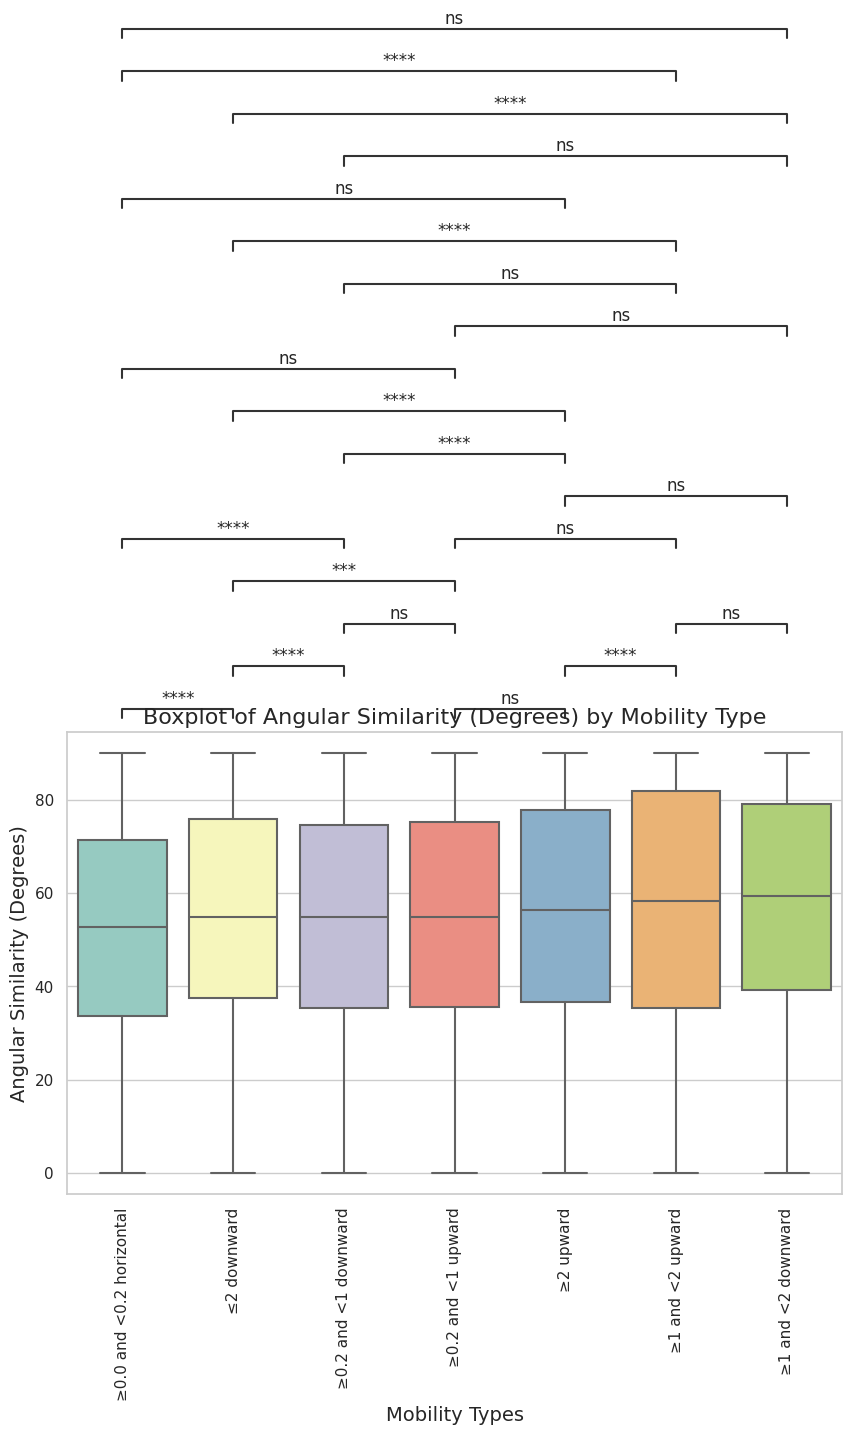

In [4]:
#@title BoxPlot Similarity Differences by Mobility Types

from scipy.stats import ttest_ind
from itertools import combinations
from statannot import add_stat_annotation

ordered_mobility_types = df_s_all.groupby('mobility')['angular_similarity_deg'].median().sort_values().index

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6)) 

box_plot = sns.boxplot(x='mobility', y='angular_similarity_deg', data=df_s_all, order=ordered_mobility_types, palette='Set3')

# Add t-test annotations
add_stat_annotation(box_plot, data=df_s_all, x='mobility', y='angular_similarity_deg', 
                    box_pairs=list(combinations(ordered_mobility_types, 2)), 
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)

plt.xlabel('Mobility Types', fontsize=14)
plt.ylabel('Angular Similarity (Degrees)', fontsize=14)
plt.title('Boxplot of Angular Similarity (Degrees) by Mobility Type', fontsize=16)
plt.xticks(rotation=90)
plt.show()

# **Q&A**
**The median goes up only slightly for upward mobility transitions**
* *Perhaps we should cluster the trajectories based on impact differences between the source and target institutions instead of defining it in this way?*

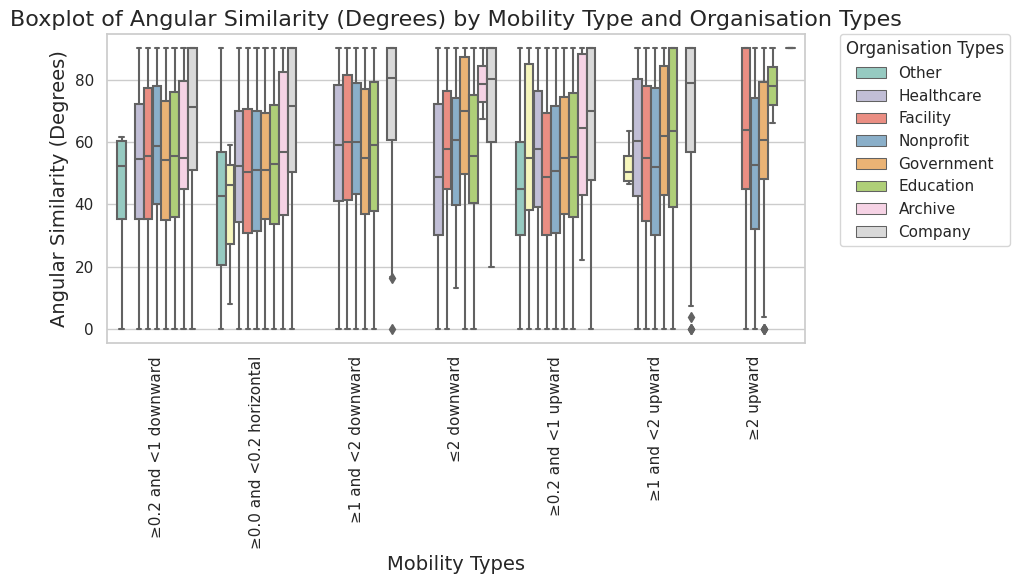

In [5]:
#@title Boxplot Similarity Differences by Mobility Types and Org Types

df_s_all = df_s_all.merge(organisations_metadata
                          , left_on='t_grid_id_target'
                          , right_on='id').drop_duplicates().reset_index(drop=True)

# Calculate the median values for each group and sort them
group_medians = df_s_all.groupby(['mobility', 'types'])['angular_similarity_deg'].median().reset_index()
group_medians_sorted = group_medians.sort_values(by='angular_similarity_deg')

# Create a new column 'group_order' to store the sorted order
df_s_all['group_order'] = df_s_all.apply(lambda row: group_medians_sorted[(group_medians_sorted['mobility'] == row['mobility']) &
                                                                         (group_medians_sorted['types'] == row['types'])].index[0], axis=1)

ordered_mobility_types = df_s_all['mobility'].unique()
ordered_types = group_medians_sorted['types'].unique()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a boxplot with an additional grouping by 'types' and ordered by the median
box_plot = sns.boxplot(x='mobility', y='angular_similarity_deg', hue='types', data=df_s_all,
                       order=ordered_mobility_types, hue_order=ordered_types, palette='Set3')

plt.xlabel('Mobility Types', fontsize=14)
plt.ylabel('Angular Similarity (Degrees)', fontsize=14)
plt.title('Boxplot of Angular Similarity (Degrees) by Mobility Type and Organisation Types', fontsize=16)
plt.xticks(rotation=90)
plt.legend(title='Organisation Types', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


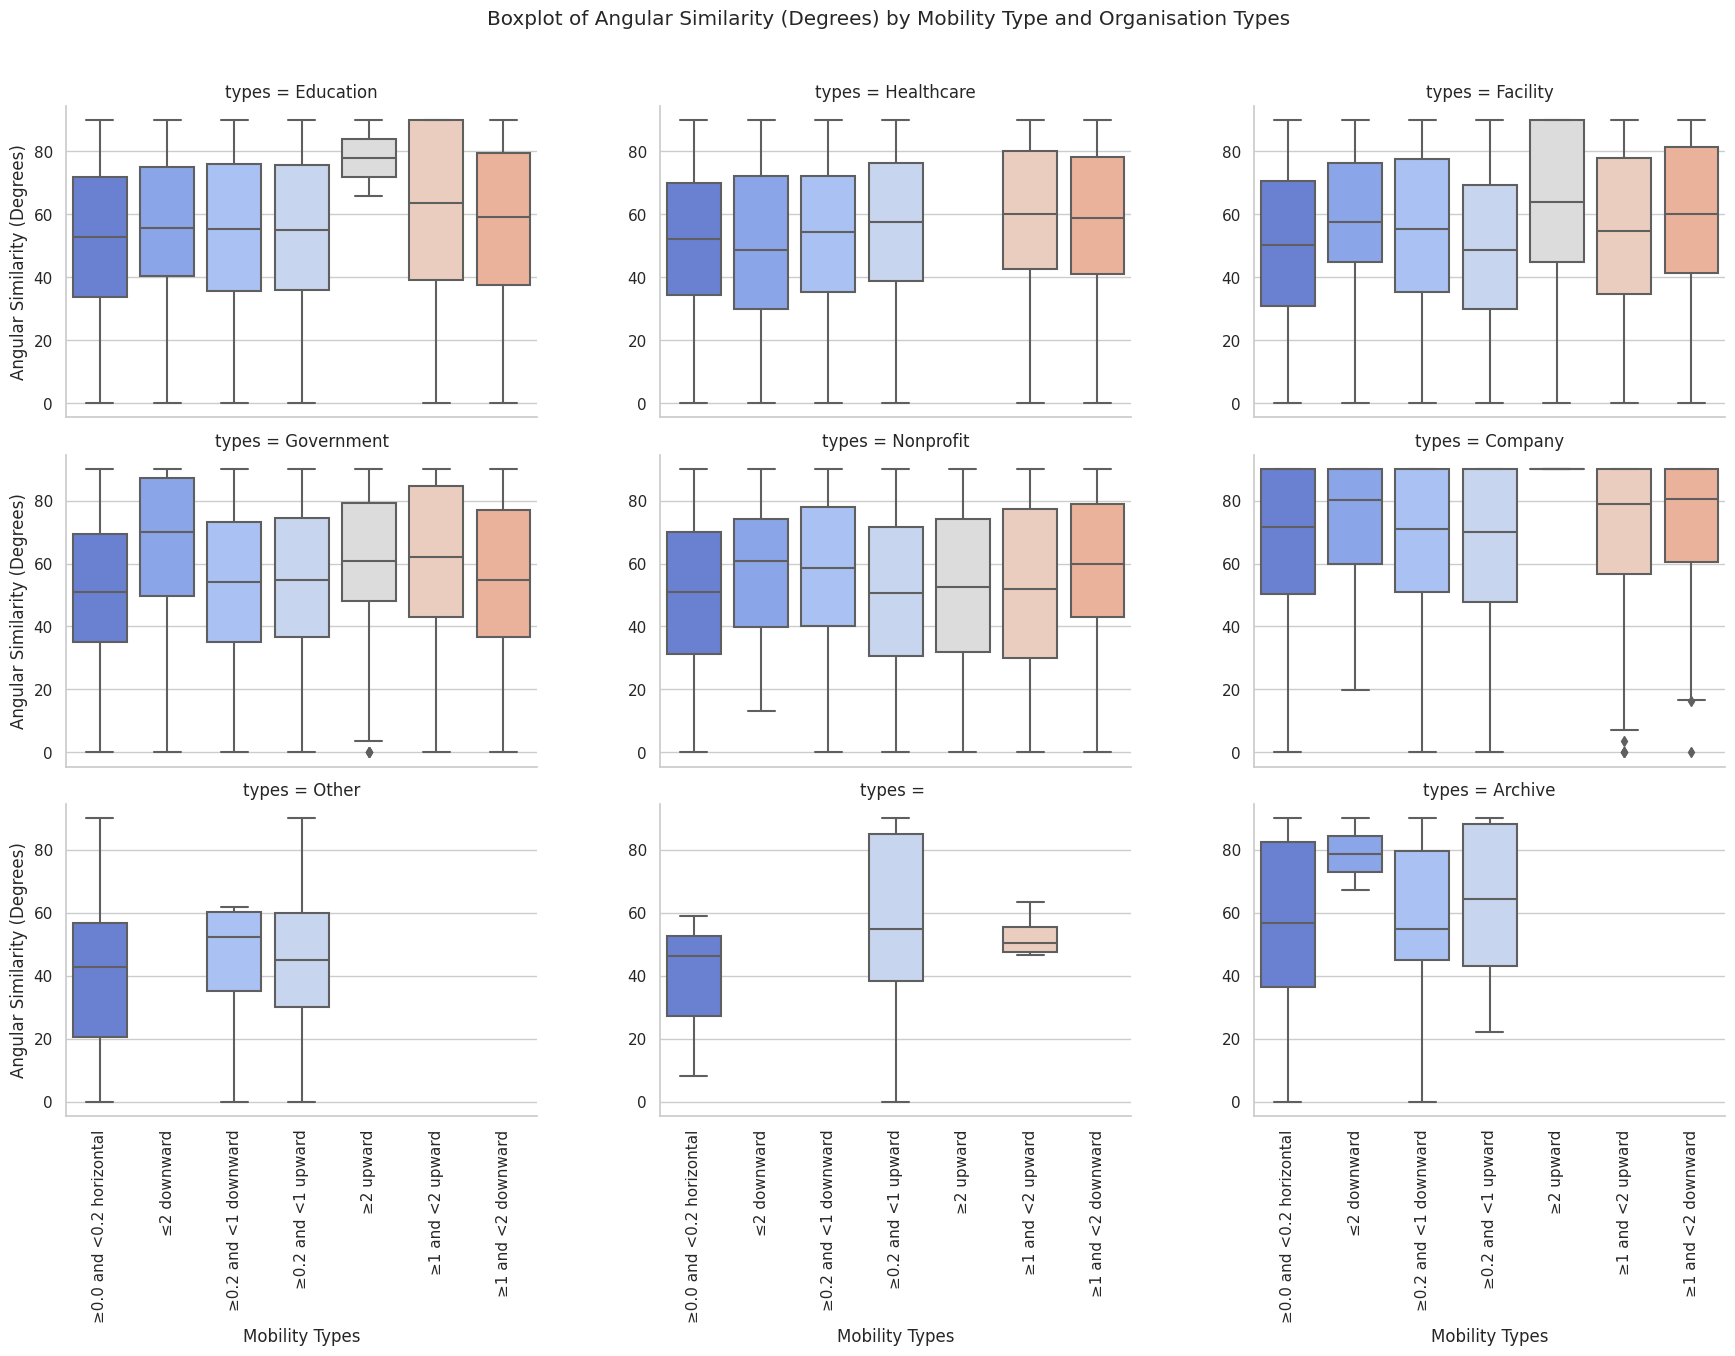

In [14]:
#@title Boxplot Similarity Differences by Mobility Types and Org Types

# calculate medians and sort mobility types
medians = df_s_all.groupby(['mobility'])['angular_similarity_deg'].median().sort_values()
df_s_all['mobility'] = pd.Categorical(df_s_all['mobility'], categories=medians.index, ordered=True)

# Define a color palette
palette = sns.color_palette("coolwarm", len(df_s_all['types'].unique()))

g = sns.FacetGrid(df_s_all, col='types', col_wrap=3, sharey=False, height=4, aspect=1.5)
g.map(sns.boxplot, 'mobility', 'angular_similarity_deg', order=medians.index, palette=palette)

# Iterate thorugh each axis
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

g.set_axis_labels("Mobility Types", "Angular Similarity (Degrees)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Boxplot of Angular Similarity (Degrees) by Mobility Type and Organisation Types')

plt.show()

# ToDo:
* Simplify categories
* Cluster trajectories (?)

In [6]:
print(df_s_all.columns)

Index(['researcher_id', 'time1', 'time2', 'grid_id', 'organization_name',
       'mncs', 't_grid_id_target', 'angular_similarity_deg',
       't_organization_name_target', 't_mncs_target',
       'performance_ratio_sending_org', 'performance_ratio_receiving_org',
       'mncs_diff', 'mobility', 'id', 'name', 'status', 'established', 'types',
       'wikipedia_url', 'latitude', 'longitude', 'city', 'country',
       'country_code', 'group_order'],
      dtype='object')


In [25]:
#@title Perfomance ratio & diff -- Education
df_edu['performance_ratio_receiving_org'] = df_edu['t_mncs_target'] / df_edu['mncs']
df_edu['performance_ratio_sending_org'] = df_edu['mncs'] / df_edu['t_mncs_target']
df_edu['mncs_diff'] =  df_edu['t_mncs_target'] - df_edu['mncs'] # when is higher positive then upward mobility, if negative then downward mobility

# mark upward or downward mobility
# mark upward or downward mobility
df_edu['mobility'] = 'unknown'

df_edu.loc[(df_edu['mncs_diff'] >= 0.20) & (df_edu['mncs_diff'] < 1.0), 'mobility'] = '≥0.2 and <1 upward'
df_edu.loc[(df_edu['mncs_diff'] >= 1.0) & (df_edu['mncs_diff'] < 2.0), 'mobility'] = '≥1 and <2 upward'
df_edu.loc[df_edu['mncs_diff'] >= 2.0, 'mobility'] = '≥2 upward'

df_edu.loc[(df_edu['mncs_diff'] > -1.0) & (df_edu['mncs_diff'] <= -0.20), 'mobility'] = '≥0.2 and <1 downward'
df_edu.loc[(df_edu['mncs_diff'] > -2.0) & (df_edu['mncs_diff'] <= -1.0), 'mobility'] = '≥1 and <2 downward'
df_edu.loc[df_edu['mncs_diff'] <= -2.0, 'mobility'] = '≤2 downward'

df_edu.loc[(0.0 <= df_edu['mncs_diff']) & (df_edu['mncs_diff'] < 0.20), 'mobility'] = '≥0.0 and <0.2 horizontal'
df_edu.loc[(-0.20 < df_edu['mncs_diff']) & (df_edu['mncs_diff'] < 0.0), 'mobility'] = '≥0.0 and <0.2 horizontal'


#df.loc[((df['mncs'] >= 2.0) & (df['t_mncs_target'] >= 2.0)), 'mobility'] = 'high-to-high'
#df.loc[(((df['mncs'] >= 0) & (df['mncs'] < 1.0)) & ((df['t_mncs_target'] >= 0) & (df['t_mncs_target'] < 1.0))) | (((df['t_mncs_target'] >= 0) & (df['t_mncs_target'] < 1.0)) & ((df['mncs'] >= 0) & (df['mncs'] < 1.0))), 'mobility'] = 'low-to-low'

#df[['organization_name', 'mncs','t_organization_name_target','t_mncs_target', 'performance_ratio_target','performance_ratio_source']].head(1)

# create a new simplified dataset for analysis
df_s = df_edu[['researcher_id', 'time1', 'time2','grid_id', 'organization_name'
, 'mncs','t_grid_id_target','angular_similarity_deg', 't_organization_name_target','t_mncs_target'
, 'performance_ratio_sending_org','performance_ratio_receiving_org'
, 'mncs_diff', 'mobility']].reset_index(drop=True)

print(df_s.columns)
#df_s.head(1000)
unknown_mobility = df_s[df_s['mobility'] == 'unknown'].head(10)
#unknown_mobility.head(50)

Index(['researcher_id', 'time1', 'time2', 'grid_id', 'organization_name',
       'mncs', 't_grid_id_target', 'angular_similarity_deg',
       't_organization_name_target', 't_mncs_target',
       'performance_ratio_sending_org', 'performance_ratio_receiving_org',
       'mncs_diff', 'mobility'],
      dtype='object')


# ToDo

*   Redo the calculation using the rank of PP(top1%), or MNCS, try P(top1%)
*   The rank is more meaningful than MNCS differences
*   This creates a continuous measure that we can average
*   Create new categories
*   +100 stream upwards | -100 stream downwards, between 0 and 100 that's horizontal



In [26]:
#@title Overall Similarity Medians -- all types
source_avg = df_edu['performance_ratio_sending_org'].median()
target_avg = df_edu['performance_ratio_receiving_org'].median()
diff_avg= df_edu['mncs_diff'].median()

print(f"Median performance ratio for source institutions: {source_avg}")
print(f"Median performance ratio for source institutions: {source_avg}")
print(f"Median performance difference between source and target institutions: {diff_avg}")

Median performance ratio for source institutions: 1.0100300839168126
Median performance ratio for source institutions: 1.0100300839168126
Median performance difference between source and target institutions: -0.011548763000000184


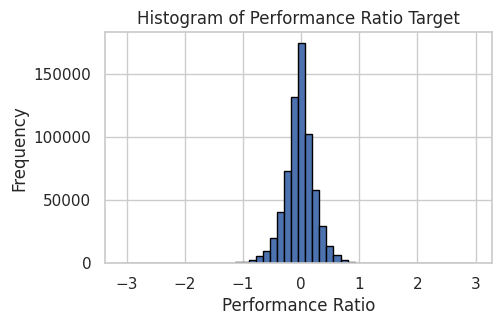

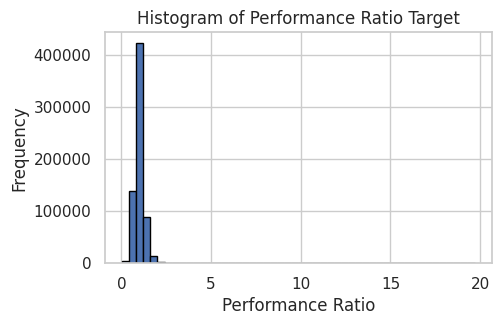

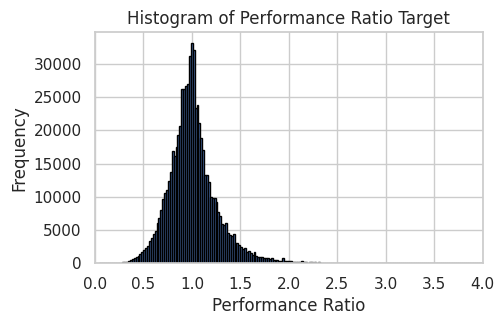

In [28]:
#@title Upward vs Downard mobility histogram -- all types
# Plot a histogram for the performance_ratio
plt.figure(figsize=(5, 3))
plt.hist(np.log(df['performance_ratio_receiving_org']), bins=50, edgecolor='black')
plt.xlabel('Performance Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Performance Ratio Target')
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(df['performance_ratio_receiving_org'], bins=50, edgecolor='black')
plt.xlabel('Performance Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Performance Ratio Target')
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(df['performance_ratio_receiving_org'], bins=1000, edgecolor='black')
plt.xlabel('Performance Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Performance Ratio Target')
plt.xlim(0, 4)  # Set the x-axis limits
plt.show()

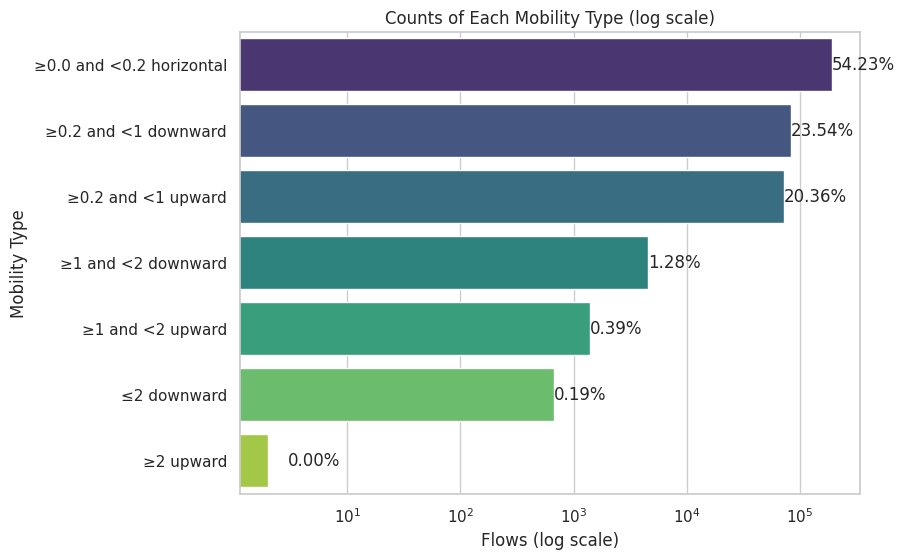

<ipython-input-29-bd0a382c84e4>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



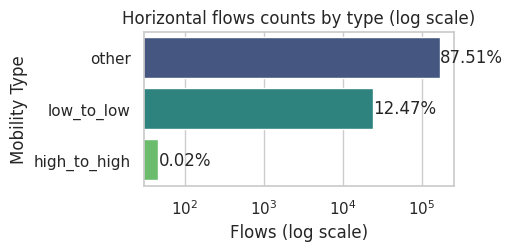

In [29]:
#@title Mobility types -- all org types
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

mobility_counts = df_s['mobility'].value_counts().reset_index()
mobility_counts.columns = ['mobility', 'count']

# Calculate percentages
total_count = mobility_counts['count'].sum()
mobility_counts['percentage'] = (mobility_counts['count'] / total_count) * 100

ax = sns.barplot(y="mobility", x="count", data=mobility_counts, palette="viridis", order=mobility_counts['mobility'])

plt.ylabel('Mobility Type')
plt.xlabel('Flows (log scale)')
plt.title('Counts of Each Mobility Type (log scale)')

ax.set_xscale("log")

# Adding percentage labels
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 1,
            p.get_y() + p.get_height() / 2,
            f'{mobility_counts.loc[i, "percentage"]:.2f}%',
            ha="left", va="center")
plt.show()

###############################################################################

horizontal_mobility = df_s.loc[df_s['mobility'] == '≥0.0 and <0.2 horizontal']

horizontal_mobility.loc[(horizontal_mobility['mncs'] >= 2.0) & (horizontal_mobility['t_mncs_target'] >= 2.0), 'mobility2'] = 'high_to_high'
horizontal_mobility.loc[(horizontal_mobility['mncs'] <= 1.1) & (horizontal_mobility['t_mncs_target'] <= 1.1), 'mobility2'] = 'low_to_low'
horizontal_mobility.loc[~(((horizontal_mobility['mncs'] >= 2.0) & (horizontal_mobility['t_mncs_target'] >= 2.0)) | ((horizontal_mobility['mncs'] <= 1.1) & (horizontal_mobility['t_mncs_target'] <= 1.1))), 'mobility2'] = 'other'


plt.figure(figsize=(4, 2))
sns.set(style="whitegrid")

horizontal_mobility_counts = horizontal_mobility['mobility2'].value_counts().reset_index()
horizontal_mobility_counts.columns = ['mobility2', 'count']

# Calculate percentages
horizontal_total_count = horizontal_mobility_counts['count'].sum()
horizontal_mobility_counts['percentage'] = (horizontal_mobility_counts['count'] / horizontal_total_count) * 100

ax = sns.barplot(y="mobility2", x="count", data=horizontal_mobility_counts, palette="viridis", order=horizontal_mobility_counts['mobility2'])

plt.ylabel('Mobility Type')
plt.xlabel('Flows (log scale)')
plt.title('Horizontal flows counts by type (log scale)')

ax.set_xscale("log")

# Adding percentage labels
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 1,
            p.get_y() + p.get_height() / 2,
            f'{horizontal_mobility_counts.loc[i, "percentage"]:.2f}%',
            ha="left", va="center")
plt.show()


* This is a graph of inequality of mobility
* Mobility is not veichuke




*   of the flows that are horizontal, how many of them are between high impact institutions?
*   of the flows that are horizontal, how many of them are between low impact institutions?

Most flows seem to between medium impact institutions, very few flows between very high impact institutions (mncs > 2.0)

In [30]:
mean = np.mean(df_s['mncs_diff'])
std_dev = np.std(df_s['mncs_diff'])

fig = px.histogram(df_s, x='mncs_diff', nbins=1000, histnorm='probability density', range_x=[-3, 3], 
                   marginal=None, opacity=0.8)

x_values = np.linspace(mean - 3.5 * std_dev, mean + 3.5 * std_dev, 100)
y_values = stats.norm.pdf(x_values, mean, std_dev)

normal_dist = go.Scatter(
    x=x_values,
    y=y_values,
    mode='lines',
    name='Normal Distribution',
    line=dict(color='red', width=2)
)

fig.add_trace(normal_dist)

fig.update_layout(
    title=dict(text='Distribution of mncs_diff with Fitted Normal Distribution', font=dict(family="Liberation Serif", size=24)),
    xaxis=dict(title='mncs_diff', range=[-3, 3], tickfont=dict(family="Liberation Serif", size=20), 
               showline=True, linecolor='black', linewidth=1),
    yaxis=dict(title='Density', tickfont=dict(family="Liberation Serif", size=20), 
               showline=True, linecolor='black', linewidth=1),
    showlegend=True,
    legend=dict(font=dict(family="Liberation Serif", size=20)),
    width=600,
    height=400,
    template='plotly_white',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

In [31]:
mean_angular_similarity = df_s.groupby('mobility')['angular_similarity_deg'].mean().reset_index()
print(mean_angular_similarity)

median_angular_similarity = df_s.groupby('mobility')['angular_similarity_deg'].median().reset_index()
print(median_angular_similarity)

                   mobility  angular_similarity_deg
0               ≤2 downward               55.530997
1  ≥0.0 and <0.2 horizontal               52.025647
2      ≥0.2 and <1 downward               54.485031
3        ≥0.2 and <1 upward               54.375575
4        ≥1 and <2 downward               56.312899
5          ≥1 and <2 upward               58.812024
6                 ≥2 upward               77.952579
                   mobility  angular_similarity_deg
0               ≤2 downward               55.590514
1  ≥0.0 and <0.2 horizontal               52.913310
2      ≥0.2 and <1 downward               55.462416
3        ≥0.2 and <1 upward               55.150095
4        ≥1 and <2 downward               59.036243
5          ≥1 and <2 upward               63.434949
6                 ≥2 upward               77.952579


**It seems that on average people change moderately regardless of mobility type**

# NEXT STEPS:

*   get scientists indicators, it seems that at institutional level there is nothing interesting. The individual level looks far more promising!
*   look at countries' source-target dynamics
*   make boxplots for institution types (get the types)
*   match scientists based on bibliometric indicators and see how they differ in the probability of switching topics
*   look at the relationship between individuals changing activity and academic age
*   redo the country pairs  and do a new one for institution pairs



**For the most part researchers tend to move between comparable ranks**\
**Moving to an institution of a much higher rank from a lower rank is a rare activity**